### Where does the scaling work or does not work?

In [62]:
import cmocean as cmo
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from netCDF4 import Dataset
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [10]:
# CONSTANTS AND SCALES

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh = 97.5 # head depth
Hr = 132.0 # rim depth at DnS
No = 5.5E-3 # Initial stratification at shelf-break depth
f = 9.66E-5 # Coriois parameter 
kv = 1E-5   # base case background vertical diffusivity
kbg = 1E-5  # base case canyon vertical diffusivity
t = 6.5 # diffusion timescale, days 
U = 0.36 # incoming velocity base case, m/s

# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)


In [43]:
# SCALING SCHEME (WITH DIMENSIONS)

def Cbar(grad, Hs, Hr, Co):
    '''
    INPUT
    grad :float: Scaled tracer gradient [C]/m
    Hs: float: Shelf-break depth (m)
    Hr: float: Rim depth (m)
    Co: float: Initial concentration near shelf break [C]
    RETURNS 
    approx concentration of upwelled water. See equation 26 in paper 1
    '''
    return(((0.01*(grad*(Hs+Hr)/2.0))+1.0)*Co)

def dTrdz(dTr0, Hs, Zup, Zdifup, Hh):
    '''
    INPUT
    dTr0: float: Initial tracer gradient near shelf break [C]/m
    Zup: float: depth of upwelling (m)
    Zdifup: float: squeezing effect due to locally enchanced diffusivity (m)
    Hh: float: Head depth (m)
    RETURNS
    dTrdz: float: Scaled tracer gradient near canyon head. See equation 22.
    '''
    return(-dTr0*(4.17*(1+((Zup+Zdifup)/Hh))-3.25))

def PhiHA(s, N, U, f, W, L):
    '''
    INPUT
    s: float: shelf slope
    N: float: initial stratification
    U: float: incomming velocity
    W: float: Mid-length width of the canyon
    L: float: Canyon length
    f: float: Coriolis Parameter
    RETURNS
     Upwelling flux: float: as calculated by Howatt and Allen, 2013.
    '''
    Se = (s*N)/(f*((F(Ro(U,f,W))/Ro(U,f,L))**(1/2)))
    return((U*W*Dh(f,L,N))*((0.91*(F(Ro(U,f,W))**(3/2))*(Ro(U,f,L)**(1/2))*((1-1.21*Se)**3))+0.07))

def PhiTr(Phi, Capprox):
    '''
    INPUT
    Phi: float: upwelling flux as calulated by Howatt adn Allen, 2013. Function PhiHA.
    Capprox: float: Approx concentration of upwelled water. Function Cbar.
    RETURNS
     Tracer flux upwelled onto the shelf: flux: Phi*Capprox.
    '''
    return(Phi*Capprox)
    
def Z(f, U, R, L, N):
    '''
    INPUT
    U: float: incomming velocity
    R: float: Radius of curvature shelf-break isobath
    f: float: Coriolis Parameter
    L: float: Canyon length
    N: float: initial stratification
    RETURNS
    Depth of upwelling from Allen and Hickey, 2010.
    '''
    return(((f*U*F(Ro(U,f,R))*L)**(0.5))/N)

def Zdif(t, kv, kbg):
    '''
    INPUT
    t : float: timescale for upwelling (sec)
    kv: float: vertical diffusivity within the canyon
    kbg: float: background vertical diffusivity
    RETURNS
    Zdif: float: squeezing effect due to locally enchanced diffusivity (m)
    '''
    return(np.sqrt(t*3600*24*(kv-kbg)))


In [12]:
import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

import canyon_records_tracers
recordsTr = canyon_records_tracers.main()

In [13]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'

ptracers_file_parab = '/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/run01/ptracersGlob.nc'

ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'

time = state.variables['T']
depth = grid.variables['RC']

fileBAR = ('/data/kramosmu/results/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run01.csv')
fileBARNoC = ('/data/kramosmu/results/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run02.csv') 

fileLWR = ('/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/HCW_TrMass_CNTDIFF_7Tr_run01.csv')
fileLWRNoC = ('/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/HCW_TrMass_CNTDIFF_7Tr_run02.csv') 

dfBAR = pd.read_csv(fileBAR)
dfBARnoc = pd.read_csv(fileBARNoC)

dfLWR = pd.read_csv(fileLWR)
dfLWRnoc = pd.read_csv(fileLWRNoC)                

In [14]:
labels_Bark = ['Lin','Sal','Oxy','Nit','Sil','Pho','NitA','Met']
colours_Bark = ['purple','blue','green','gold','orange','red','orchid','teal']

labels_Para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
colours_Para = ['tan','0.2','beige','0.4','0.5','brown','0.7'] 
sizes_Para = [11,7,7,7,7,7,7] 

In [24]:
# Get tracer gradient and tracer concetration of all runs
#------------------------------------------------------------------------------------------------------------
keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

Bar_maxTr = np.empty(8)
Bar_stdTr = np.empty(8)
Bar_TrSB = np.empty(8)
Bar_Ctop = np.empty(8)

Par_maxTr = np.empty(7)
Par_stdTr = np.empty(7)
Par_TrSB = np.empty(7)
Par_Ctop = np.empty(7)

record = recordsTr[0]
ii = 0

for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/%s_profile_%s_%s.csv' 
                 % (tracer,record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:30])   
    maxd5 = np.mean(df[keys[1]][25:30])   
    maxd6 = np.mean(df[keys[2]][25:30]) 
    maxd7 = np.mean(df[keys[3]][25:30])  
    maxd8 = np.mean(df[keys[4]][25:30])  
    maxd0 = df[key0][29]
    
    
    Bar_maxTr[ii] = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Bar_stdTr[ii] = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Bar_TrSB[ii] = maxd0
    Bar_Ctop[ii] = df[key0][0]
    ii=ii+1
    
record = recordsTr[1]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/%s_profile_%s_%s.csv' 
                 % (tracer,record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:30])   
    maxd5 = np.mean(df[keys[1]][25:30])   
    maxd6 = np.mean(df[keys[2]][25:30]) 
    maxd7 = np.mean(df[keys[3]][25:30])  
    maxd8 = np.mean(df[keys[4]][25:30])  
    maxd0 = df[key0][29]
   
    
    Par_maxTr[ii] = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Par_stdTr[ii] = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Par_TrSB[ii] = maxd0
    Par_Ctop[ii] = df[key0][0]
    ii=ii+1

#------------------------------------------------------------------------------------------------------------
keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

Bar_dTrdz = np.empty(8)
Bar_inidTrdz = np.empty(8)
Bar_dTrdz_std = np.empty(8)
       
Par_dTrdz = np.empty(7)
Par_inidTrdz = np.empty(7)
Par_dTrdz_std = np.empty(8)

record = recordsTr[0]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                 %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
    
    Bar_dTrdz[ii] = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    Bar_inidTrdz[ii] = df[key0][30]
    Bar_dTrdz_std[ii] = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    ii = ii+1
    
record = recordsTr[1]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                 %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
 
    Par_dTrdz[ii] = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    Par_inidTrdz[ii] = df[key0][30]
    Par_dTrdz_std[ii] = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
   
    ii = ii+1    

#------------------------------------------------------------------------------------------------------------
keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon


for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
        
    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
    
 
    record.maxdTrdz = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    record.stddTrdz = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    record.inidTrdz = df[key0][30]

keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' % (record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:32])   
    maxd5 = np.mean(df[keys[1]][25:32])   
    maxd6 = np.mean(df[keys[2]][25:32]) 
    maxd7 = np.mean(df[keys[3]][25:32])  
    maxd8 = np.mean(df[keys[4]][25:32])  
    
     
    maxd0 = df[key0][29]
    
    
    record.maxTr = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    record.stdTr = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    
    
    record.TrSB = maxd0


In [57]:
select_rec = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]

for ind in select_rec:
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
   
    records[ind].TrMass = dfcan['TrMassHCW']
    recordsNoC[ind].TrMass = dfnoc['TrMassHCW']

In [25]:
Mass_Bark = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07','TrMassHCW08']
Mass_Para = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07']

rec = recordsTr[0]

In [74]:
def scale_PhiTr(dTr0, Hs, f, U, R, L, N, t, kv, kbg, Hh, Hr, W ):
    ''''''
    dTr_scaled = dTrdz(dTr0, Hs, Z(f, U, R, L, N), Zdif(t, kv, kbg), Hh)
    Capprox = Cbar(dTr_scaled, Hs, Hr, Co)
    HA = PhiHA(s, N, U, f, W, L)
    return(PhiTr(HA,Capprox), Capprox)

def model_PhiTr(mass_can_eff, time):
    ''''''
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    return(PhiTr, PhiTr_std)

Tracer	Phi err (%)	C err (%)	dTr0		 TrSB
Tr1 	3.8		14.7		0.050		13.6
Tr2 	6.1		10.3		0.059		13.6
Tr3 	4.3		13.9		0.051		13.6
Tr4 	3.4		15.4		0.049		13.6
Tr5 	1.4		18.9		0.043		13.6
Tr6 	17.0		6.3		0.113		13.6
Tr7 	20.6		1.5		-0.013		150.1
Lin 	18.6		0.7		0.002		32.2
Sal 	18.7		0.5		0.001		33.9
Oxy 	90.3		87.6		-0.186		104.1
Nit 	8.3		12.1		0.031		32.6
Sil 	2.2		18.6		0.047		47.6
Pho 	19.3		1.2		0.001		2.2
NitA 	13.1		6.2		0.007		27.7
Met 	67.1		94.9		0.375		17.5


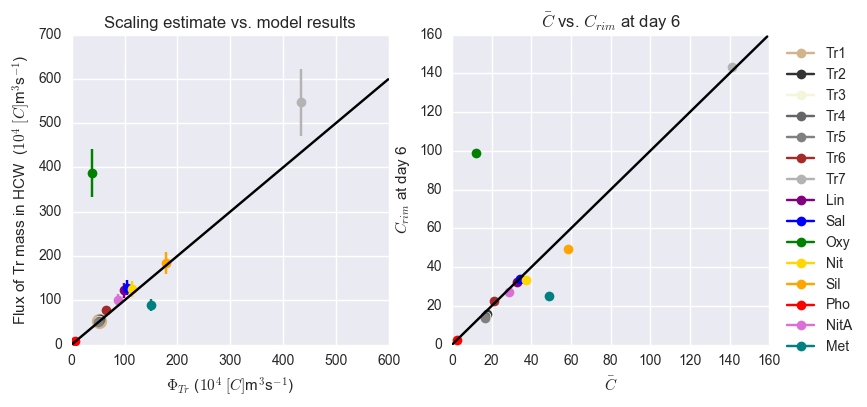

In [75]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

print ("\t".join(['Tracer', 'Phi err (%)', 'C err (%)', 'dTr0', '\t TrSB']))

rec = recordsTr[0]

for TrMass, dTr0,Co,C, lab, col, ms in zip(Mass_Para,Par_inidTrdz[:],Par_TrSB[:],Par_maxTr[:],labels_Para,colours_Para,
                                           sizes_Para):
    scaPhiTr, CC = scale_PhiTr(dTr0, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    modPhiTr, PhiTr_std = model_PhiTr(dfLWR[TrMass], time)
    
    ax1.errorbar(scaPhiTr/1E4, modPhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    err_phi = scaPhiTr/modPhiTr
    ax2.plot(CC, C, color=col, label=lab, marker='o')
    err_C = CC/C
    
    print ("%s" % (lab), "\t".join(['\t%1.1f\t\t%1.1f\t\t%1.3f\t\t%1.1f' % (abs(1-err_phi)*100, abs(1-err_C)*100, -dTr0, Co)]))
    

for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,Bar_TrSB,Bar_maxTr,labels_Bark,colours_Bark):
    
    scaPhiTr, CC = scale_PhiTr(dTr0, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    modPhiTr, PhiTr_std = model_PhiTr(dfBAR[TrMass], time)
    
    ax1.errorbar(scaPhiTr/1E4, modPhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')
    err_phi = scaPhiTr/modPhiTr
    ax2.plot(CC, C, color=col, label=lab, marker='o')
    err_C = CC/C

    print ("%s" % (lab), "\t".join(['\t%1.1f\t\t%1.1f\t\t%1.3f\t\t%1.1f' % (abs(1-err_phi)*100, abs(1-err_C)*100, -dTr0, Co)]))
   
 
ax1.set_xlabel(r'$\Phi_{Tr}$ ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_ylabel('Flux of Tr mass in HCW  ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_title('Scaling estimate vs. model results')
ax1.plot(np.arange(0,600,1),np.arange(0,600,1),'-k')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$\bar{C}$')
ax2.set_ylabel('$C_{rim}$ at day 6')
ax2.set_title(r'$\bar{C}$ vs. $C_{rim}$ at day 6')
ax2.plot(np.arange(0,160,1),np.arange(0,160,1),'-k')

Tracer	Phi err (%)	C err (%)	dTr0		 TrSB
CNTDIFF 	103.6		137.2		0.375		17.5
CNTDIFF 	125.8		139.6		0.375		17.5
CNTDIFF 	193.7		151.9		0.375		17.5
CNTDIFF 	137.6		136.8		0.375		17.5
CNTDIFF 	400.0		138.4		0.375		17.5
CNTDIFF 	55.8		139.1		0.375		17.5
CNTDIFF 	102.5		136.9		0.375		17.5
CNTDIFF 	105.6		140.0		0.375		17.5
CNTDIFF 	98.3		138.6		0.375		17.5
CNTDIFF 	146.4		142.4		0.375		17.5
3DVISC 	113.2		153.5		0.375		17.5
3DVISC 	125.9		142.5		0.375		17.5
3DVISC 	127.1		142.5		0.375		17.5
3DVISC 	115.3		153.6		0.375		17.5
3DVISC 	106.4		156.3		0.375		17.5
3DVISC 	113.8		150.2		0.375		17.5
LOWER_BF 	129.2		137.6		0.375		17.5
LOW_BF 	209.7		143.7		0.375		17.5
LOWEST_BF 	2238.1		152.6		0.375		17.5
LOWEST_BF 	421.2		150.8		0.375		17.5
LOWEST_BF 	6900.2		155.0		0.375		17.5
LOWEST_BF 	894.4		154.7		0.375		17.5
LOWEST_BF 	84.9		147.1		0.375		17.5


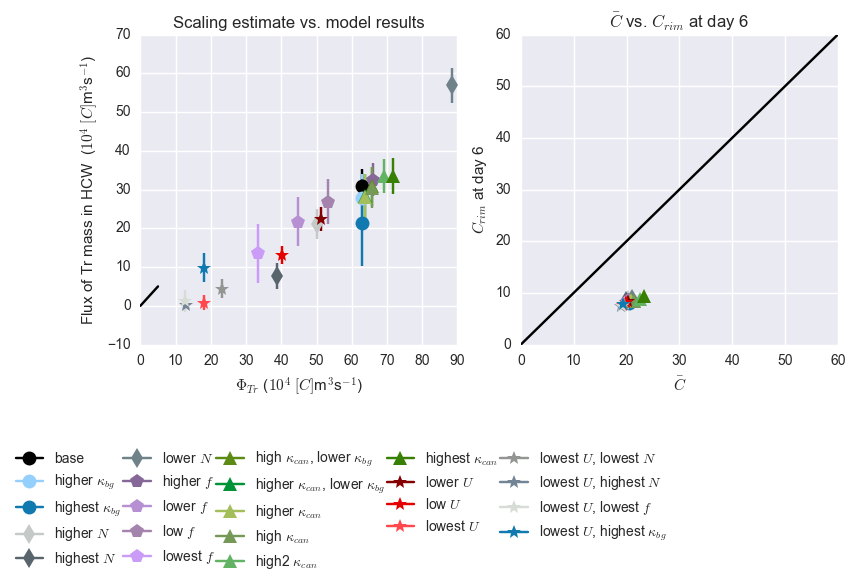

In [76]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

print ("\t".join(['Tracer', 'Phi err (%)', 'C err (%)', 'dTr0', '\t TrSB']))

for rec,recNoC in zip(records,recordsNoC):    
    
    mass_can_eff = rec.TrMass
    modPhiTr, PhiTr_std = model_PhiTr(mass_can_eff, time)
    scaPhiTr, CC = scale_PhiTr(rec.inidTrdz, Hs, rec.f, rec.u, R, L, rec.N, t, rec.kv, rec.kbg, Hh, Hr, W )
     
    ax1.errorbar(scaPhiTr/1E4, modPhiTr/1E4, yerr=PhiTr_std/1E4, 
                 color=sns.xkcd_rgb[rec.color2],
                 label=rec.label,
                 marker=rec.mstyle, markersize = 10)
    
    err_phi = scaPhiTr/modPhiTr
    C = rec.maxTr
    ax2.plot(CC, C, color=sns.xkcd_rgb[rec.color2],
             label=rec.label,
             marker=rec.mstyle, markersize = 10)
    err_C = CC/C
    
    print ("%s" % (rec.exp_code), "\t".join(['\t%1.1f\t\t%1.1f\t\t%1.3f\t\t%1.1f' % (abs(1-err_phi)*100, abs(1-err_C)*100, -dTr0, Co)]))
   
ax1.set_xlabel(r'$\Phi_{Tr}$ ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_ylabel('Flux of Tr mass in HCW  ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_title('Scaling estimate vs. model results')
ax1.plot(np.arange(0,6,1),np.arange(0,6,1),'-k')

ax2.legend(bbox_to_anchor=(0.5,-0.3),ncol=5, columnspacing=0.1)
ax2.set_xlabel(r'$\bar{C}$')
ax2.set_ylabel('$C_{rim}$ at day 6')
ax2.set_title(r'$\bar{C}$ vs. $C_{rim}$ at day 6')
ax2.plot(np.arange(0,90,30),np.arange(0,90,30),'-k')    